### Introduction to machine learning with TensorFlow

This notebook is intended to be run in a local Python environment with access to the TensorFlow package.

In [16]:
from modules.tensorflow_functions import *
from ucimlrepo import fetch_ucirepo

Read in data - we are using the abalone mollusc dataset from the UCI ML dataset repository:

In [17]:
abalones = fetch_ucirepo(id=1)

abalones_df = abalones.data.original

abalones_df.head(5)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Using the UCI ML repo package, the dataset comes with the variables already split into features and labels:

In [18]:
# Features:
abalones_x = abalones.data.features

# Labels:
abalones_y = abalones.data.targets

print("The features of this dataset are:\n")
for col in abalones_x.columns: print(col)

print("\nThe labels of this dataset are:\n")
for col in abalones_y.columns: print(col)

The features of this dataset are:

Sex
Length
Diameter
Height
Whole_weight
Shucked_weight
Viscera_weight
Shell_weight

The labels of this dataset are:

Rings


So the machine learning task is to use some combination of the sex, length, diameter, height and weights of the abalone molluscs to predict the number of shell rings.

We can see our feature set includes the variable `Sex`, which is a categorical variable. We will recode this into dummy variables:

In [19]:
encoded_sex = pd.get_dummies(abalones_df["Sex"], prefix = "Sex", dtype = int)

abalones_df = pd.concat([abalones_df, encoded_sex], axis = 1)

abalones_df.head(5)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_F,Sex_I,Sex_M
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,0,1
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0,0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,1,0


We can drop the original `Sex` variable from the feature set now that we have replaced it with numeric dummy variables:

In [20]:
abalones_df = abalones_df.drop("Sex", axis = 1)

We will use functions defined in [tensorflow_functions.py](modules/tensorflow_functions.py) to build and train a linear regression model on the abalone DataFrame.

The machine learning model will depend on three hyperparameters:

- [Learning rate](https://developers.google.com/machine-learning/glossary/#learning-rate)
- [Epochs](https://developers.google.com/machine-learning/glossary/#epoch)
- [Batch size](https://developers.google.com/machine-learning/glossary/#batch_size)

It will also depend on the features we select to predict the label, `Rings`. We can first show a correlation matrix to guide our selection of feature:

In [21]:
abalones_df.corr()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_F,Sex_I,Sex_M
Length,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720,0.309666,-0.551465,0.236543
Diameter,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660,0.318626,-0.564315,0.240376
Height,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467,0.298421,-0.518552,0.215459
Whole_weight,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390,0.299741,-0.557592,0.252038
Shucked_weight,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884,0.263991,-0.521842,0.251793
Viscera_weight,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819,0.308444,-0.556081,0.242194
Shell_weight,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574,0.306319,-0.546953,0.235391
Rings,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000,0.250279,-0.436063,0.181831
Sex_F,0.309666,0.318626,0.298421,0.299741,0.263991,0.308444,0.306319,0.250279,1.000000,-0.464298,-0.512528
Sex_I,-0.551465,-0.564315,-0.518552,-0.557592,-0.521842,-0.556081,-0.546953,-0.436063,-0.464298,1.000000,-0.522541


`Shell_weight` is the feature that is most strongly correlated with our label, `Rings`

Epoch 1/30
42/42 [==============================] - 0s 999us/step - loss: 93.5850 - root_mean_squared_error: 9.6739
Epoch 2/30
42/42 [==============================] - 0s 851us/step - loss: 83.9005 - root_mean_squared_error: 9.1597
Epoch 3/30
42/42 [==============================] - 0s 885us/step - loss: 75.0898 - root_mean_squared_error: 8.6654
Epoch 4/30
42/42 [==============================] - 0s 787us/step - loss: 66.8360 - root_mean_squared_error: 8.1753
Epoch 5/30
42/42 [==============================] - 0s 874us/step - loss: 59.1612 - root_mean_squared_error: 7.6916
Epoch 6/30
42/42 [==============================] - 0s 877us/step - loss: 51.9595 - root_mean_squared_error: 7.2083
Epoch 7/30
42/42 [==============================] - 0s 851us/step - loss: 45.3238 - root_mean_squared_error: 6.7323
Epoch 8/30
42/42 [==============================] - 0s 851us/step - loss: 39.2314 - root_mean_squared_error: 6.2635
Epoch 9/30
42/42 [==============================] - 0s 882us/step - loss

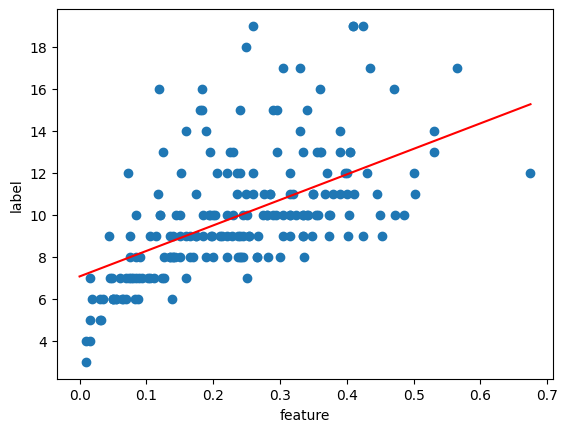

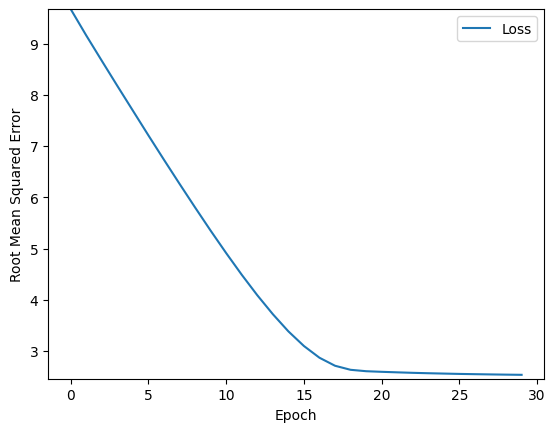

In [22]:
# Define hyperparameters
model_learning_rate = 0.01
model_epochs = 30
model_batch_size = 100

# Set label and features
model_label = "Rings"
model_feature = "Shell_weight"

# Build model
base_model = build_lr_model(learning_rate = model_learning_rate)

# Train model
weight, bias, epochs, rmse = train_model(
    model =  base_model,
    df = abalones_df,
    feature = model_feature,
    label = model_label,
    epochs = model_epochs,
    batch_size = model_batch_size
)

# Plot the model
plot_the_model(
    df = abalones_df,
    trained_weight = weight,
    trained_bias = bias,
    feature = model_feature,
    label = model_label
)
plot_the_loss_curve(epochs, rmse)